In [1]:
import ROOT as r
import coffea
import coffea.hist as hist
from coffea.nanoevents.methods import vector
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

from pyjet import cluster
import awkward as ak
import mplhep


from sklearn.cluster import DBSCAN
import numba

Welcome to JupyROOT 6.22/00


In [ ]:
# events_raw = uproot.open("../displacedJetMuon_ntupler_84_HNL.root")['ntuples/llp']
events_raw = uproot.open("~/eos/llp/zerobias18/displacedJetMuon_ntupler.root")['ntuples/llp']
df = coffea.processor.LazyDataFrame(events_raw,entrystop=100)

start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
events = uproot.lazy(df._tree)
events = events[start:stop]

nRechits = events.ncscRechits
rechits = ak.zip({
    "eta":events.cscRechitsEta,
    "phi":events.cscRechitsPhi,
    'x':events.cscRechitsX,
    'y':events.cscRechitsY,    
    'z':events.cscRechitsZ, 
    't':events.cscRechitsTpeak,
    'twire':events.cscRechitsTwire,
    'station':events.cscRechitsStation,
    'chamber':events.cscRechitsChamber,
})

In [ ]:
rechits.t

In [4]:
len(events_raw)

736

In [46]:
len(events)

100

In [189]:
df.size

10

11

In [164]:
events.cscRechits

<Array [[64.9, 64.4, 101, ... 41.1, 27, 44.3]] type='1517 * var * float32'>

In [204]:
avgx = ak.mean(rechits.x,axis=1)
avgy = ak.mean(rechits.y,axis=1)

In [31]:
ak.sum((abs(rechits.chamber)==12) | (abs(rechits.chamber)==11),axis=1)

<Array [2, 50, 29, 44, 43, ... 26, 7, 52, 13] type='100 * int64'>

In [26]:
ak.sum(abs(rechits.chamber)==11,axis=1)

<Array [2, 50, 23, 44, 43, ... 26, 7, 52, 13] type='100 * int64'>

In [208]:
rechits[1486]

<Array [{eta: 2.37, ... chamber: -42}] type='251 * {"eta": float32, "phi": float...'>

In [272]:
def buildDBcluster(rechits,labels):
    cls={
        'eta':[],
        "phi":[],
        'x':[],
        'y':[],
        'z':[],
        "eta_sd":[],
        "phi_sd":[],
        "width":[],
        "size":[],
        'time':[],
        'nStation':[],        
        'avgStation':[],
        'nStation10':[],        
        'avgStation10':[],        
        'nCS':0
    }
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    cls['nCS']    = n_clusters_    
    for iCs in range(n_clusters_):
        ##select rechits for this cluster
        rh = rechits[labels==iCs]
        cls['x'].append(np.mean(rh.x))
        cls['y'].append(np.mean(rh.y))        
        cls['z'].append(np.mean(rh.z))
        theta = np.arctan((np.mean(rh.x)**2+np.mean(rh.y)**2)**0.5/abs(np.mean(rh.z)))
        eta=-1*np.sign(np.mean(rh.z))*np.log( np.tan(theta/2))
        cls['eta'].append(eta)
        cls['phi'].append(np.arctan2(np.mean(rh.y),np.mean(rh.x)))
        
        cls['time'].append(np.mean(rh.t))                        
        cls['eta_sd'].append(np.std(rh.eta))
        cls['phi_sd'].append(np.std(rh.phi))
        cls['width'].append((np.std(rh.phi)**2+np.std(rh.eta)**2)**0.5)
        cls['avgStation'].append(np.mean(rh.station))
        cls['nStation'].append(len(set(rh.station)))        
        
        station10mask=[False]*(len(rh))
        for station in set(rh.station):
            if ak.sum(rh.station==station,axis=0)>10:
                station10mask=((station10mask)|(rh.station==station))

        cls['avgStation10'].append(np.mean(rh.station[station10mask]))
        cls['nStation10'].append(len(set(rh.station[station10mask])))                
        cls['size'].append(len(rh.eta))        
        
        
    return cls    

In [214]:
np.sign([0.1,-2])

array([ 1., -1.])

In [239]:
set(rechits[1486].station)

{-4, -3, -2, -1, 1, 3, 4}

In [268]:
[False]*len(rechits[1486]) | (rechits[1486].station==3)

<Array [False, False, False, ... False, False] type='251 * bool'>

In [253]:
(rechits[1486].station==4) | (rechits[1486].station==3)

<Array [False, False, False, ... False, False] type='251 * bool'>

In [258]:
mask=(rechits[1486].station==4) | (rechits[1486].station==3)

In [260]:
np.mean(rechits[1486].station[mask])

3.7857142857142856

In [270]:
@numba.jit
def dR(x,y):
    dphi=(x[1]-y[1] +np.pi) %(2*np.pi)-np.pi
    deta=(x[0]-y[0])    
    return (dphi**2+deta**2)**0.5


def DBScan(rechits,nCore,eps):
    rechits=rechits[ak.num(rechits)>0]    
    points=ak.zip([rechits.eta,rechits.phi],highlevel=False)
    alllabels=[]
    masks=[]
    nClusters=[]
    clusters=[]
    for (x,rh) in zip(points,rechits):
        x=np.stack(ak.unzip(x),axis=1)## format into DBSCAN x=[ [x1,y1],[x2,y2] ... ]
        if len(x)>0:            
            db = DBSCAN(eps=eps, min_samples=nCore,metric=dR).fit(x)
            labels = db.labels_    
            dbclusters= buildDBcluster(rh, labels)

            clusters.append(dbclusters)
            alllabels.append(labels)
    return ak.Array(clusters),ak.Array(alllabels)



In [273]:
%time clusters,labels = DBScan(rechits,50,0.2)

CPU times: user 24.3 s, sys: 275 ms, total: 24.5 s
Wall time: 24.4 s


In [178]:
rechits=rechits[ak.num(rechits)>0]

In [277]:
clusters.avgStation10[1486]

<Array [-1, -2] type='2 * float64'>

In [231]:
np.unique(rechits[labels==1][1486].station.to_numpy())

array([-2], dtype=int32)

In [ ]:
rechits[labels==1][1486].x

In [12]:
a=np.zeros(10)


In [13]:
a.append(1)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [3]:
# @numba.jit(forceobj=True)
def RechitMask(rechits,cls_rh):
    label_eta = np.zeros(len(rechits)).astype(bool)
#     label_phi = np.zeros(len(rechits)).astype(bool)        
    for i in cls_rh['eta']:
        label_eta[np.where(rechits.eta==i)]=True
#         label_phi[np.where(rechits.phi==j)]=True    
        
#     return ak.flatten([np.where(rechits.eta==i) for i in cls_rh['eta']],axis=None)    
    return (label_eta)
#     return (np.ones(len(rechits)).astype(bool))

def buildCAcluster(rechits,jets):
    cls={
        'eta':[],
        "phi":[],
        'x':[],
        'y':[],
        'z':[],
        "eta_sd":[],
        "phi_sd":[],
        "width":[],
        "size":[],
        'time':[],
        'nStation':[],        
        'avgStation':[],
        'nStation10':[],        
        'avgStation10':[],        
#         'nCS':[0]
    }
    n_clusters_ = len(jets)
#     cls['nCS']    = n_clusters_    
    for jet in jets:
        ##select rechits for this cluster
        cls_rh = jet.constituents_array()
        ## match to original rechits with eta
#         print("ncluster",len(cls_rh['eta']))
#         print("rh mask eta",len([np.where(rechits.eta==i) for i in cls_rh['eta']]))
#         print("flat(rh mask eta)",len(ak.flatten([np.where(rechits.eta==i) for i in cls_rh['eta']],axis=None)))
    
        label = RechitMask(rechits,cls_rh)

        rh = rechits[label]
        cls['x'].append(np.mean(rh.x))
        cls['y'].append(np.mean(rh.y))        
        cls['z'].append(np.mean(rh.z))
        theta = np.arctan((np.mean(rh.x)**2+np.mean(rh.y)**2)**0.5/abs(np.mean(rh.z)))
        eta=-1*np.sign(np.mean(rh.z))*np.log( np.tan(theta/2))
        cls['eta'].append(eta)
        cls['phi'].append(np.arctan2(np.mean(rh.y),np.mean(rh.x)))
        
        cls['time'].append(np.mean(rh.t))                        
        cls['eta_sd'].append(np.std(rh.eta))
        cls['phi_sd'].append(np.std(rh.phi))
        cls['width'].append((np.std(rh.phi)**2+np.std(rh.eta)**2)**0.5)
        cls['avgStation'].append(np.mean(rh.station))
        cls['nStation'].append(len(set(rh.station)))        
        
        station10mask=[False]*(len(rh))
        for station in set(rh.station):
            if ak.sum(rh.station==station,axis=0)>10:
                station10mask=((station10mask)|(rh.station==station))

        cls['avgStation10'].append(np.mean(rh.station[station10mask]))
        cls['nStation10'].append(len(set(rh.station[station10mask])))                
        cls['size'].append(len(rh.eta))        
        
        
    return cls    

def CAcluster(rechits,dR=1.0,nCore=50):
    vectors=ak.zip({
        'pt':ak.ones_like(rechits.phi),
        'eta':rechits.eta,
        'phi':rechits.phi,
        'mass':ak.zeros_like(rechits.phi)
    })
    alljets=[]
    clusters=[]
    for (v,rh) in zip(vectors,rechits):    
        v = ak.to_numpy(v)
        v = np.array([(i[0],i[1],i[2],i[3]) for i in v],
                     dtype=[(u'pT', '<f8'), (u'eta', '<f8'), (u'phi', '<f8'), (u'mass', '<f8')])
        clusterVals = cluster(v,R=dR,algo="cambridge")
        #include all rechits with ptmin=0
        _jets = clusterVals.inclusive_jets(ptmin=0)
        jets=[j for j in _jets if len(j)>=nCore]
        alljets.append(jets)
        cls = buildCAcluster(rh,jets)
        clusters.append(cls)

    return ak.Array(clusters),alljets

In [24]:
%time cls,alljets=CAcluster(rechits,0.3,10)

CPU times: user 5.56 s, sys: 9.4 ms, total: 5.57 s
Wall time: 5.56 s


In [49]:
%timeit cls=CAcluster(rechits,0.3,50)

1.64 s ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
ak.flatten(cls.size)

<Array [58, 21, 15, 11, 24, ... 10, 24, 12, 12] type='230 * int64'>

In [33]:
ak.sum(ak.num(cls,axis=1).time)

230

In [17]:
ak.to_list(cls[1])

{'eta': [2.295048615206612],
 'phi': [-0.9967730400571765],
 'x': [92.41015625],
 'y': [-142.9038927801724],
 'z': [835.9368938577586],
 'eta_sd': [0.04090649159168858],
 'phi_sd': [0.02628929012211964],
 'width': [0.04862579386977518],
 'size': [58],
 'time': [26.493780728044182],
 'nStation': [4],
 'avgStation': [2.2413793103448274],
 'nStation10': [1],
 'avgStation10': [2.0]}

In [39]:
jet = alljets[1]

In [53]:
cls_rh=jet[0].constituents_array()
cls_rh['eta']

array([2.05126452, 2.33695459, 2.32135701, 2.32927942, 2.32895708,
       2.32906389, 2.3291564 , 2.31781054, 2.30492854, 2.32133126,
       2.31316972, 2.31304002, 2.31308794, 2.31311798, 2.34201455,
       2.33212376, 2.33241844, 2.32754278, 2.32296014, 2.32768059,
       2.34238601, 2.31850767, 2.32322669, 2.33276224, 2.3279624 ,
       2.32792473, 2.27457237, 2.27414727, 2.27153182, 2.27339554,
       2.27273941, 2.27223206, 2.28601313, 2.28606486, 2.2860508 ,
       2.29064584, 2.29521894, 2.29523039, 2.29522562, 2.29459286,
       2.29452991, 2.29027629, 2.2948873 , 2.29495263, 2.28563094,
       2.28579855, 2.28577018, 2.25911117, 2.25465775, 2.26801944,
       2.2770102 , 2.27250504, 2.25869107, 2.25441575, 2.27637339,
       2.27181053, 2.27666759, 2.26775312])

In [47]:
rh = rechits[1]

In [60]:
len(np.unique(cls_rh['eta']))==len(cls_rh)

True

In [54]:
np.where(rh.eta==cls_rh['eta'][0])

(<Array [81] type='1 * int64'>,)

In [ ]:
def mapClsToRechit(rh,cls):
    etamap={}
    [etamap[j] for i,j in enumerate(cls)]
    
    
    
    
    

In [33]:
cls[2].to_list()

{'eta': [],
 'phi': [],
 'x': [],
 'y': [],
 'z': [],
 'eta_sd': [],
 'phi_sd': [],
 'width': [],
 'size': [],
 'time': [],
 'nStation': [],
 'avgStation': [],
 'nStation10': [],
 'avgStation10': []}

In [316]:
cls[1487].to_list()

{'eta': [-1.033362574280165, -1.5984016196317399],
 'phi': [-2.9410799584781198, -2.2560813484665667],
 'x': [-652.3069458007812, -199.08037109375],
 'y': [-132.57737731933594, -243.54125],
 'z': [-816.9747314453125, -745.953671875],
 'eta_sd': [0.013561769735682277, 0.01783628774358376],
 'phi_sd': [0.02397111810952692, 0.02708330505932041],
 'width': [0.027541534121841453, 0.032428977372222625],
 'size': [128, 50],
 'time': [0.3813062906265259, -25.91061279296875],
 'nStation': [1, 3],
 'avgStation': [-2.0, -1.68],
 'nStation10': [1, 1],
 'avgStation10': [-2.0, -1.0]}

In [321]:
cls[:2].to_list()

[{'eta': [],
  'phi': [],
  'x': [],
  'y': [],
  'z': [],
  'eta_sd': [],
  'phi_sd': [],
  'width': [],
  'size': [],
  'time': [],
  'nStation': [],
  'avgStation': [],
  'nStation10': [],
  'avgStation10': []},
 {'eta': [2.301122840206597],
  'phi': [-0.9953530521465528],
  'x': [91.65210389254386],
  'y': [-141.291229783443],
  'z': [832.4072094298245],
  'eta_sd': [0.02532197317273709],
  'phi_sd': [0.02559687236580657],
  'width': [0.036005585681560696],
  'size': [57],
  'time': [26.687060975191887],
  'nStation': [4],
  'avgStation': [2.210526315789474],
  'nStation10': [1],
  'avgStation10': [2.0]}]

In [313]:
cls[cls.time<0][1487].to_list()

{'eta': [-1.5984016196317399],
 'phi': [-2.2560813484665667],
 'x': [-199.08037109375],
 'y': [-243.54125],
 'z': [-745.953671875],
 'eta_sd': [0.01783628774358376],
 'phi_sd': [0.02708330505932041],
 'width': [0.032428977372222625],
 'size': [50],
 'time': [-25.91061279296875],
 'nStation': [3],
 'avgStation': [-1.68],
 'nStation10': [1],
 'avgStation10': [-1.0]}

In [328]:
cls[cls.time<12.5].nStation10

<Array [[], [], [], [], ... [], [], [], []] type='1517 * var * int64'>

In [327]:
ak.num(cls.time,axis=1)

<Array [0, 1, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='1517 * int64'>

In [246]:
(cls.time<0)[31]

<Array [False, False] type='2 * bool'>

In [283]:
ak.mask(cls,cls.time<0)[1487].time.to_list()

[None, [0.3813062906265259, -25.91061279296875]]

In [281]:
cls

<Array [{eta: [], phi: [], ... nCS: 0}] type='1517 * {"eta": var * float64, "phi...'>

In [278]:
cls[1487].to_list()

{'eta': [-1.033362574280165, -1.5984016196317399],
 'phi': [-2.9410799584781198, -2.2560813484665667],
 'x': [-652.3069458007812, -199.08037109375],
 'y': [-132.57737731933594, -243.54125],
 'z': [-816.9747314453125, -745.953671875],
 'eta_sd': [0.013561769735682277, 0.01783628774358376],
 'phi_sd': [0.02397111810952692, 0.02708330505932041],
 'width': [0.027541534121841453, 0.032428977372222625],
 'size': [128, 50],
 'time': [0.3813062906265259, -25.91061279296875],
 'nStation': [1, 3],
 'avgStation': [-2.0, -1.68],
 'nStation10': [1, 1],
 'avgStation10': [-2.0, -1.0],
 'nCS': 2}

In [282]:
cls[cls.time<0]

ValueError: too many jagged slice dimensions for array

(https://github.com/scikit-hep/awkward-1.0/blob/1.2.0/src/libawkward/array/NumpyArray.cpp#L3721)

In [256]:
a = ak.Array([
 [],
 [1,2,3],
 [-1,2]
])

In [258]:
(a<0).to_list()

[[], [False, False, False], [True, False]]

In [259]:
a[a<0]

<Array [[], [], [-1]] type='3 * var * int64'>

In [37]:
np.where(ak.num(rechits)>100)

(<Array [1, 5, 7, 9] type='4 * int64'>,)

In [38]:
original=rechits[9].phi

cls1=jets[9][0].constituents_array()
cls2=jets[9][1].constituents_array()

labels = ak.flatten([np.where(original==i) for i in cls1['phi']],axis=None)

NameError: name 'jets' is not defined

In [157]:
labels

<Array [227, 230, 228, 229, ... 173, 165, 169] type='128 * int64'>

In [131]:
original[labels]

<Array [-2.88, -2.88, -2.88, ... -2.94, -2.94] type='128 * float32'>

In [159]:
def buildCAcluster(rechits,jets):
    cls={
        'eta':[],
        "phi":[],
        'x':[],
        'y':[],
        'z':[],
        "eta_sd":[],
        "phi_sd":[],
        "width":[],
        "size":[],
        'time':[],
        'nStation':[],        
        'avgStation':[],
        'nStation10':[],        
        'avgStation10':[],        
        'nCS':0
    }
    n_clusters_ = len(jets)
    cls['nCS']    = n_clusters_    
    for jet in jets:
        ##select rechits for this cluster
        cls_rh = jet.constituents_array()
        ## match to original rechits with eta
        labels = ak.flatten([np.where(rechits.eta==i) for i in cls_rh['eta']],axis=None)
        rh = rechits[labels]
        cls['x'].append(np.mean(rh.x))
        cls['y'].append(np.mean(rh.y))        
        cls['z'].append(np.mean(rh.z))
        theta = np.arctan((np.mean(rh.x)**2+np.mean(rh.y)**2)**0.5/abs(np.mean(rh.z)))
        eta=-1*np.sign(np.mean(rh.z))*np.log( np.tan(theta/2))
        cls['eta'].append(eta)
        cls['phi'].append(np.arctan2(np.mean(rh.y),np.mean(rh.x)))
        
        cls['time'].append(np.mean(rh.t))                        
        cls['eta_sd'].append(np.std(rh.eta))
        cls['phi_sd'].append(np.std(rh.phi))
        cls['width'].append((np.std(rh.phi)**2+np.std(rh.eta)**2)**0.5)
        cls['avgStation'].append(np.mean(rh.station))
        cls['nStation'].append(len(set(rh.station)))        
        
        station10mask=[False]*(len(rh))
        for station in set(rh.station):
            if ak.sum(rh.station==station,axis=0)>10:
                station10mask=((station10mask)|(rh.station==station))

        cls['avgStation10'].append(np.mean(rh.station[station10mask]))
        cls['nStation10'].append(len(set(rh.station[station10mask])))                
        cls['size'].append(len(rh.eta))        
        
        
    return cls    

In [160]:
buildCAcluster(rechits[1487],jets[1487])

128
251
[227, 230, 228, 229, 134, 133, 153, 180, ... 146, 213, 167, 192, 161, 173, 165, 169]
50
251
[98, 102, 82, 86, 90, 94, 81, 85, 97, 101, ... 79, 83, 95, 99, 73, 71, 72, 87, 91]


{'eta': [-1.033362574280165, -1.5984016196317399],
 'phi': [-2.9410799584781198, -2.2560813484665667],
 'x': [-652.3069458007812, -199.08037109375],
 'y': [-132.57737731933594, -243.54125],
 'z': [-816.9747314453125, -745.953671875],
 'eta_sd': [0.013561769735682277, 0.01783628774358376],
 'phi_sd': [0.02397111810952692, 0.02708330505932041],
 'width': [0.027541534121841453, 0.032428977372222625],
 'size': [128, 50],
 'time': [0.3813062906265259, -25.91061279296875],
 'nStation': [1, 3],
 'avgStation': [-2.0, -1.68],
 'nStation10': [1, 1],
 'avgStation10': [-2.0, -1.0],
 'nCS': 2}

In [95]:
arr = np.array([1.01,2.02,3.03,4.04,5.05])
b = np.array([2.02,1.01,5.05,4.04,3.03,6,7])

In [98]:
label = ak.flatten([np.where(arr==i) for i in b],axis=None)

## Event Inspection

In [2]:
import sys
sys.path.insert(0,"../")
import cluster

In [53]:
#     'zerobias18':[ "~/eos/llp/zerobias18/displacedJetMuon_ntupler.root"]

events_raw = uproot.open("~/eos/llp/zerobias18/displacedJetMuon_ntupler.root")['ntuples/llp']
df = coffea.processor.LazyDataFrame(events_raw,entrystart=700,entrystop=900)

start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
events = uproot.lazy(df._tree)
events = events[start:stop]

nRechits = events.ncscRechits
rechits = ak.zip({
    "eta":events.cscRechitsEta,
    "phi":events.cscRechitsPhi,
    'x':events.cscRechitsX,
    'y':events.cscRechitsY,    
    'z':events.cscRechitsZ, 
    't':events.cscRechitsTpeak,
    'twire':events.cscRechitsTwire,
    'station':events.cscRechitsStation,
    'chamber':events.cscRechitsChamber,
})
eventinfo = ak.zip({
    'runNumber':events.runNum,
    'lumiNum':events.lumiNum,
    'eventNum':events.eventNum,
})

def plot(index, cls_DB, cls_CA, rechits):
    rechits = rechits[ak.num(rechits)>0]
    for i in index:
        print("Plotting index = ",i, "nRechits = ",len(rechits[i]))
        ncols=2
        nrows=1
        figsize=(8,4)
        fig, axs = plt.subplots(1,2,
                            figsize=[ncols*figsize[0],nrows*figsize[1]])    
        axs = axs.flatten()

        axs[0].plot(rechits[i].eta, rechits[i].phi, 'x',markerfacecolor='r',label="rechits")
        axs[0].plot(cls_DB[i].eta, cls_DB[i].phi, 'o',label='cluster')

        axs[1].plot(rechits[i].eta, rechits[i].phi, 'x',markerfacecolor='r',label="rechits")
        axs[1].plot(cls_CA[i].eta, cls_CA[i].phi, 'o',label='cluster')

        print("DB Cluster times:", cls_DB[i].time)
        print("DB Cluster size:", cls_DB[i].size) 
        
        print("CA Cluster times:", cls_CA[i].time)
        print("CA Cluster size:", cls_CA[i].size)

        axs[0].set_title('Estimated number of DB clusters: %d' % nDB[i])
        axs[1].set_title('Estimated number of CA clusters: %d' % nCA[i])    
        for j in [0,1]:
            axs[j].set_xlabel('eta')
            axs[j].set_ylabel('phi')
            axs[j].set_xlim(-3,3)
            axs[j].set_ylim(-1.1*np.pi,1.1*np.pi)    
            axs[j].legend()
        plt.tight_layout()
        plt.show()
        
        

In [33]:
eventinfo[77].to_list()

{'runNumber': 323513, 'lumiNum': 346, 'eventNum': 401521342}

In [54]:
len(events)

200

In [55]:
cls_CA = cluster.CAcluster(rechits,dR=0.2,nCore=50)
cls_DB = cluster.DBScan(rechits,eps=0.2,nCore=50)

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


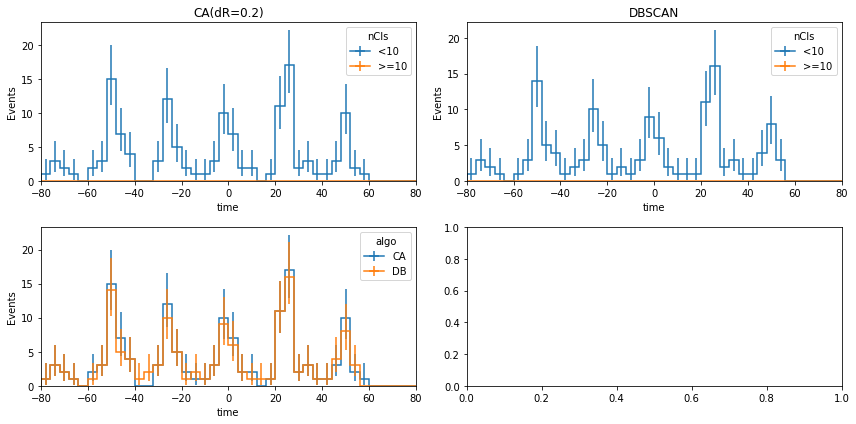

In [56]:
h = hist.Hist("Events",
              hist.Cat("algo","algo"),
              hist.Cat("nCls",'nCls'),
              hist.Bin("time",'time',40, -80, 80))

nCA = ak.num(cls_CA,axis=1).time
nDB = ak.num(cls_DB,axis=1).time

h.fill(algo='DB',nCls="<10",time = ak.flatten(cls_DB[nDB<10].time))
h.fill(algo='DB',nCls=">=10",time = ak.flatten(cls_DB[nDB>=10].time))
h.fill(algo='CA',nCls="<10",time = ak.flatten(cls_CA[nCA<10].time))
h.fill(algo='CA',nCls=">=10",time = ak.flatten(cls_CA[nCA>=10].time))

# h.fill(algo='CA',time = ak.flatten(cls_CA.time))

fig, axs = plt.subplots(2,2,figsize=(12,6))
axs = axs.flatten()
hist.plot1d(h[0:1].project('nCls','time'),ax=axs[0],overlay='nCls')
hist.plot1d(h[1:2].project('nCls','time'),ax=axs[1],overlay='nCls')
axs[0].set_title("CA(dR=0.2)")
axs[1].set_title("DBSCAN")
hist.plot1d(h.project('algo','time'),ax=axs[2],overlay='algo')
plt.tight_layout()

In [5]:
ak.max(ak.num(cls_CA,axis=1).time)

2

In [7]:
cls_DB

<Array [{eta: [1.47], ... n_ME11_12: []}] type='194 * {"eta": var * float64, "ph...'>

In [6]:
cls_DB

<Array [{eta: [1.47], ... n_ME11_12: []}] type='194 * {"eta": var * float64, "ph...'>

In [8]:
nCA = ak.num(cls_CA,axis=1).time
nDB = ak.num(cls_DB,axis=1).time

In [9]:
print("index with different nCluster:",str(np.where((nCA - nDB)!=0)))
print("nCA with different nCluster",nCA[np.where((nCA - nDB)!=0)])
print("nDB with different nCluster",nDB[np.where((nCA - nDB)!=0)])

index with different nCluster: (<Array [23, 38, 122, 144, 178] type='5 * int64'>,)
nCA with different nCluster [2, 1, 1, 1, 2]
nDB with different nCluster [1, 0, 0, 0, 1]


In [93]:
np.where(nDB>2)

(<Array [77] type='1 * int64'>,)

<Array [6, 8, 16, 19, ... 167, 168, 174, 197] type='45 * int64'>

In [30]:
negative = np.where(ak.any(cls_CA.time<-60,axis=1))

In [31]:
negative[0]

<Array [43, 64, 76, 77, 96, 118, 119, 143] type='8 * int64'>

Plotting index =  60 nRechits =  764
DB Cluster times: [-55.9]
DB Cluster size: [726]
CA Cluster times: [-55.7, -58.5]
CA Cluster size: [671, 55]


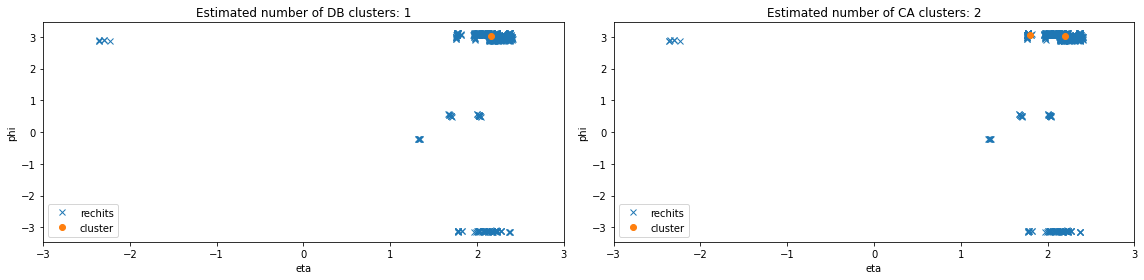

Plotting index =  77 nRechits =  11151
DB Cluster times: [-61.8, -58.1, -62.3, 2.45, -0.932, -2.14, -1.87, -0.256]
DB Cluster size: [5828, 2691, 378, 107, 1035, 396, 83, 40]
CA Cluster times: [-62.6, -61.6, -63.7, -60.3, -62.9, -0.614, ... -48, -5.31, -1.91, -49.9, -1.41]
CA Cluster size: [1430, 1359, 1250, 812, 729, 623, 514, 504, ... 114, 107, 100, 76, 76, 73, 72, 64]


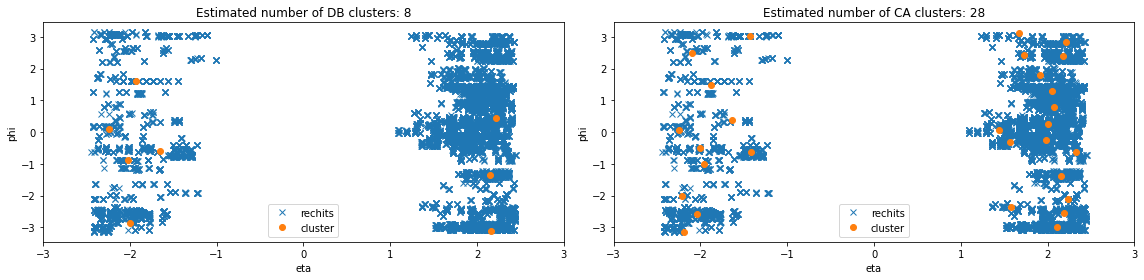

Plotting index =  100 nRechits =  285
DB Cluster times: [-25.5]
DB Cluster size: [173]
CA Cluster times: [-25.6, -24]
CA Cluster size: [179, 53]


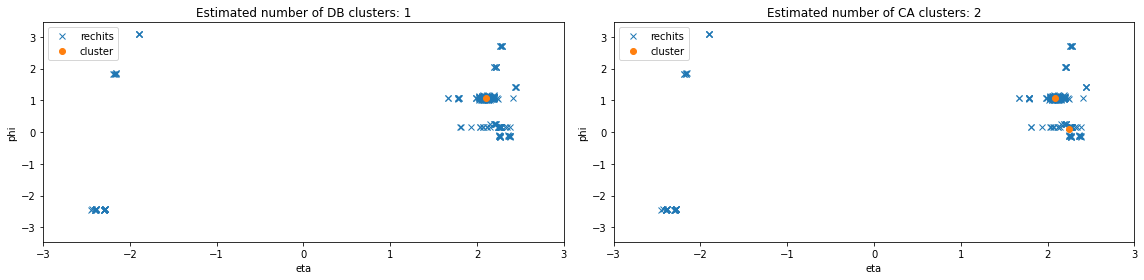

Plotting index =  149 nRechits =  508
DB Cluster times: [-48.1]
DB Cluster size: [424]
CA Cluster times: [-48.1, -21.5]
CA Cluster size: [424, 72]


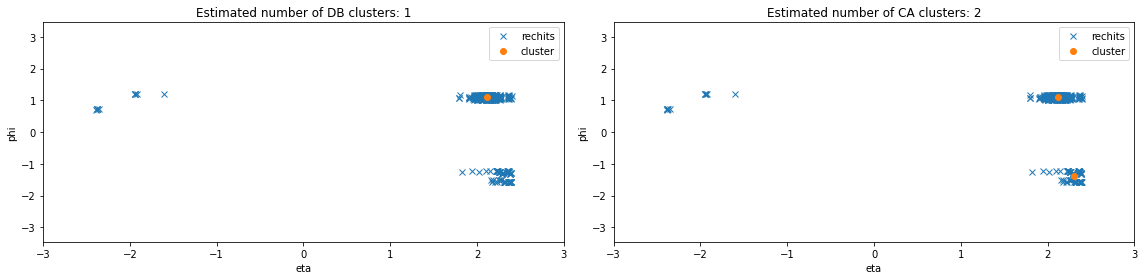

Plotting index =  165 nRechits =  618
DB Cluster times: [34.3]
DB Cluster size: [542]
CA Cluster times: [34.3, -48.8]
CA Cluster size: [542, 50]


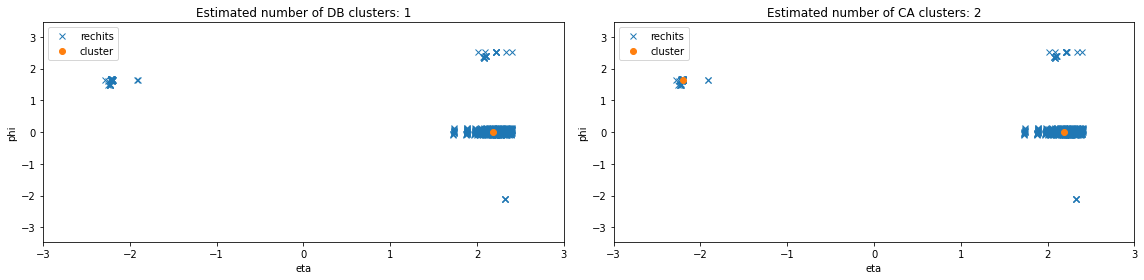

Plotting index =  175 nRechits =  71
DB Cluster times: []
DB Cluster size: []
CA Cluster times: [39.5]
CA Cluster size: [50]


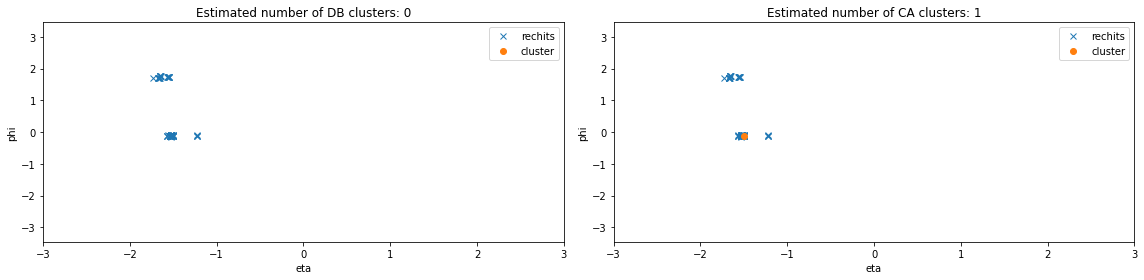

In [73]:
plot( [60, 77, 100, 149, 165, 175],cls_DB,cls_CA,rechits)

Plotting index =  43 nRechits =  259
DB Cluster times: [-73.4]
DB Cluster size: [220]
CA Cluster times: [-73.4]
CA Cluster size: [220]


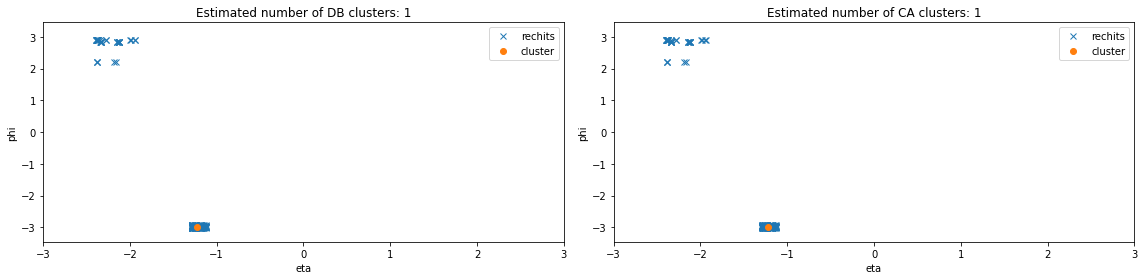

Plotting index =  64 nRechits =  151
DB Cluster times: [-79.4]
DB Cluster size: [143]
CA Cluster times: [-79.4]
CA Cluster size: [143]


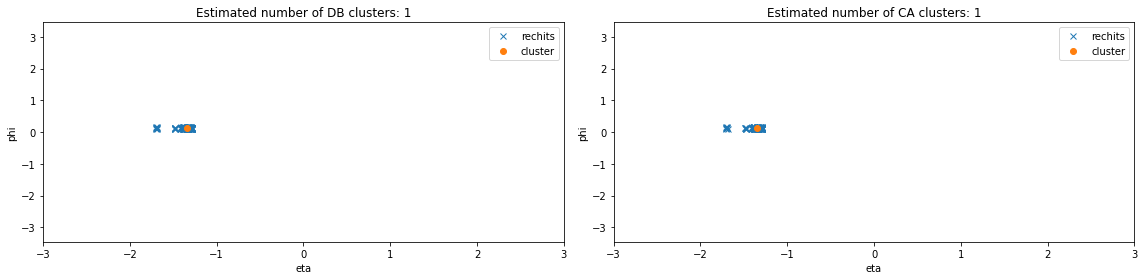

Plotting index =  76 nRechits =  432
DB Cluster times: [-62.5]
DB Cluster size: [424]
CA Cluster times: [-62.5]
CA Cluster size: [424]


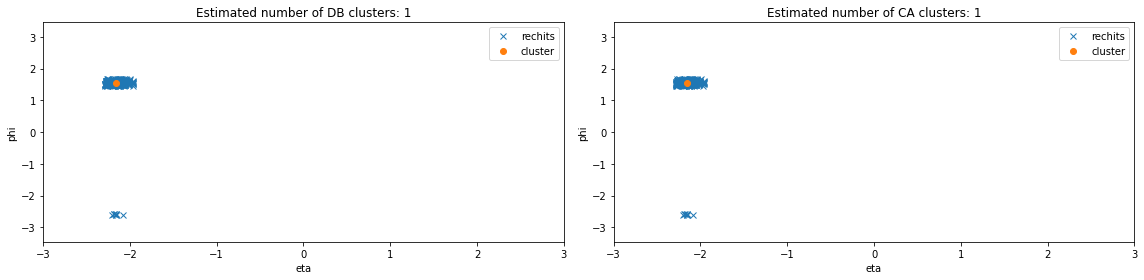

Plotting index =  77 nRechits =  11151
DB Cluster times: [-61.8, -58.1, -62.3, 2.45, -0.932, -2.14, -1.87, -0.256]
DB Cluster size: [5828, 2691, 378, 107, 1035, 396, 83, 40]
CA Cluster times: [-61.3, -59.3, -64.2, -62.3, -64.2, -65.9, ... -61.1, 3.74, -57.5, -0.786, -66.1]
CA Cluster size: [687, 559, 506, 437, 416, 344, 328, 298, 291, ... 72, 70, 67, 67, 66, 62, 58, 56, 55]


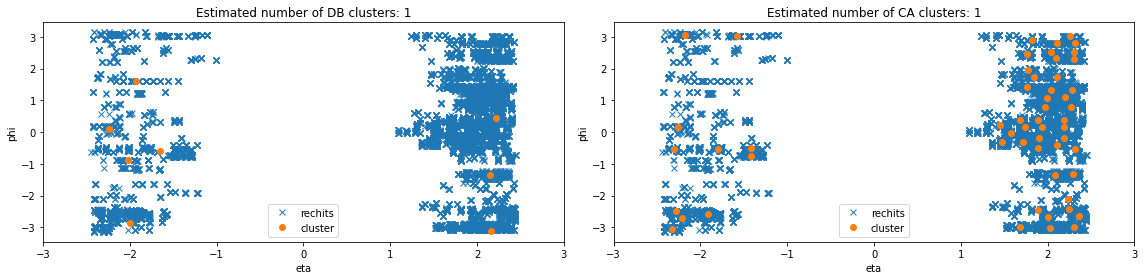

Plotting index =  96 nRechits =  76
DB Cluster times: [-77.3]
DB Cluster size: [57]
CA Cluster times: [-77.3]
CA Cluster size: [57]


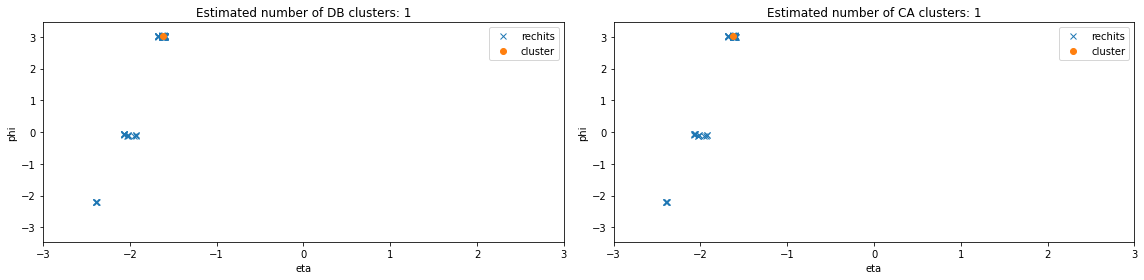

Plotting index =  118 nRechits =  80
DB Cluster times: [-74.6]
DB Cluster size: [74]
CA Cluster times: [-74.6]
CA Cluster size: [74]


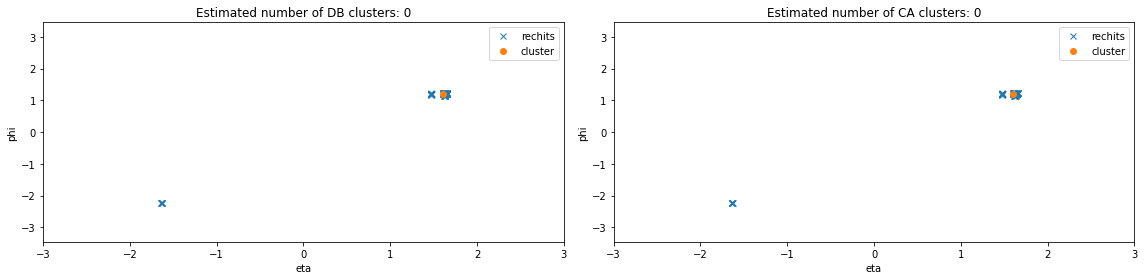

Plotting index =  119 nRechits =  211
DB Cluster times: [-75.2]
DB Cluster size: [150]
CA Cluster times: [-75.2]
CA Cluster size: [150]


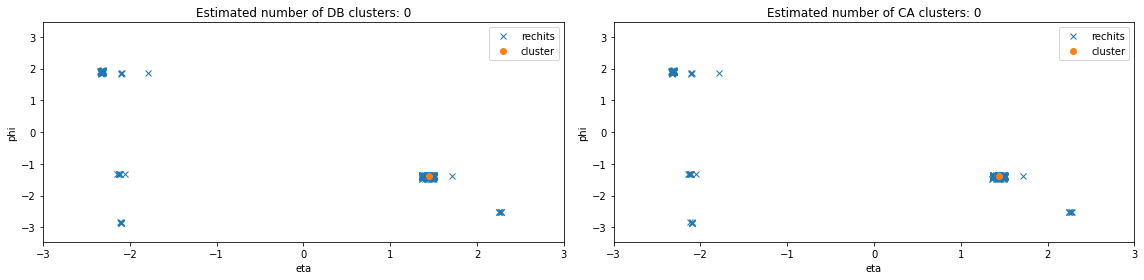

Plotting index =  143 nRechits =  356
DB Cluster times: [-68.6]
DB Cluster size: [248]
CA Cluster times: [-68.8]
CA Cluster size: [242]


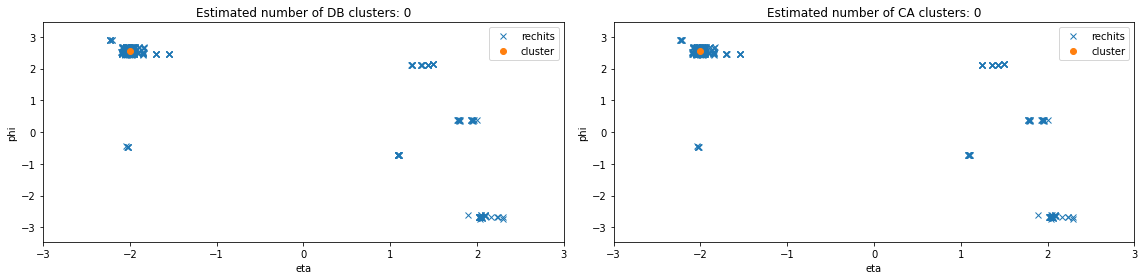

In [32]:
plot( negative[0],cls_DB,cls_CA,rechits)